In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralCoclustering

In [15]:
# Load whiskies and regions
whisky = pd.read_csv("whiskies.txt")
regions = pd.read_csv("regions.txt", header=None)
whisky["Region"] = regions

# Preview data
whisky.head()

,RowID,Distillery,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral,Postcode,Latitude,Longitude,Region
0,1,Aberfeldy,2,2,2,0,0,2,1,2,2,2,2,2,\tPH15 2EB,286580,749680,#####Regions#####
1,2,Aberlour,3,3,1,0,0,4,3,2,2,3,3,2,\tAB38 9PJ,326340,842570,Highlands
2,3,AnCnoc,1,3,2,0,0,2,0,0,2,2,3,2,\tAB5 5LI,352960,839320,Speyside
3,4,Ardbeg,4,1,4,4,0,0,2,0,1,2,1,0,\tPA42 7EB,141560,646220,Highlands
4,5,Ardmore,2,2,2,0,0,1,1,1,2,3,1,1,\tAB54 4NH,355350,829140,Islay


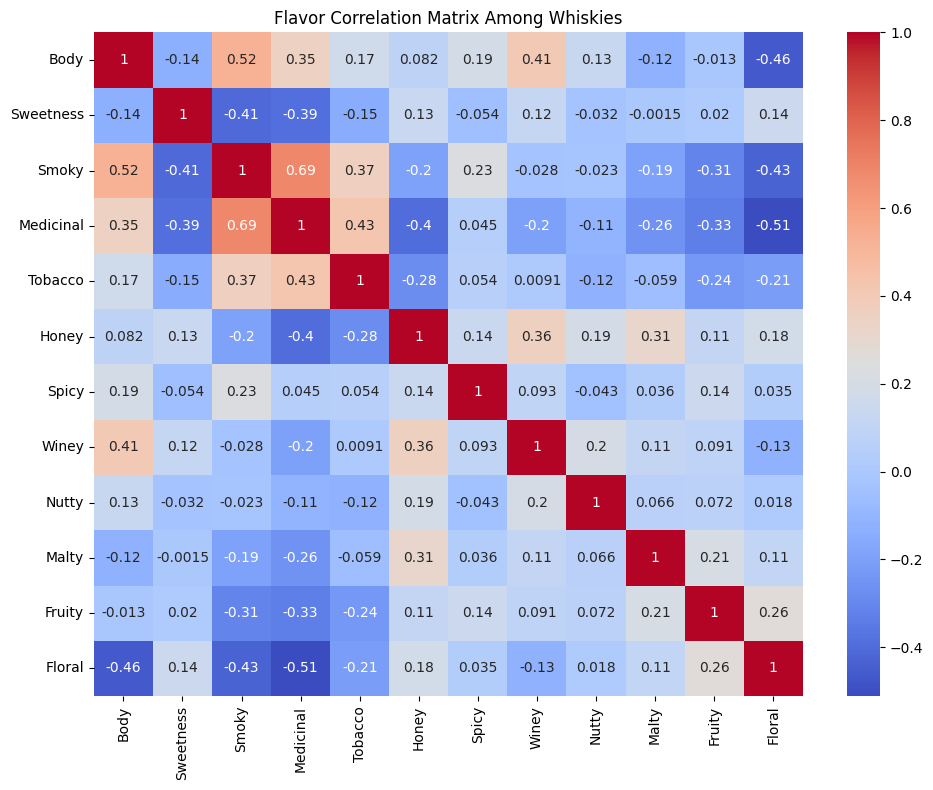

In [16]:
# Extract flavor features
flavors = whisky.iloc[:, 2:14]

# Compute correlation matrix
corr_flavors = flavors.corr()

# Visualize flavor correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_flavors, cmap="coolwarm", annot=True)
plt.title("Flavor Correlation Matrix Among Whiskies")
plt.tight_layout()
plt.show()

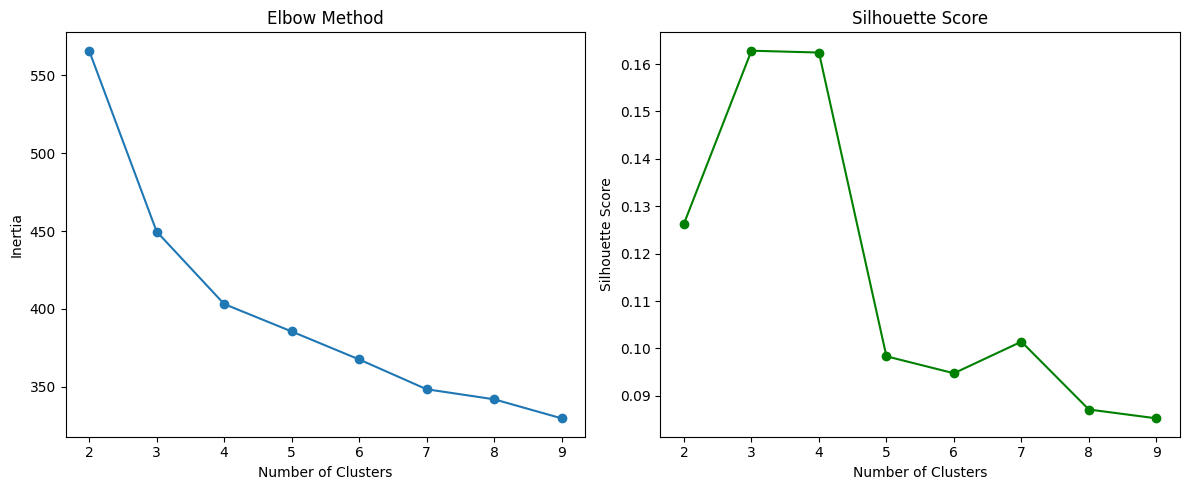

In [17]:
inertia = []
silhouette = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(flavors)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(flavors, kmeans.labels_))

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(K, silhouette, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()


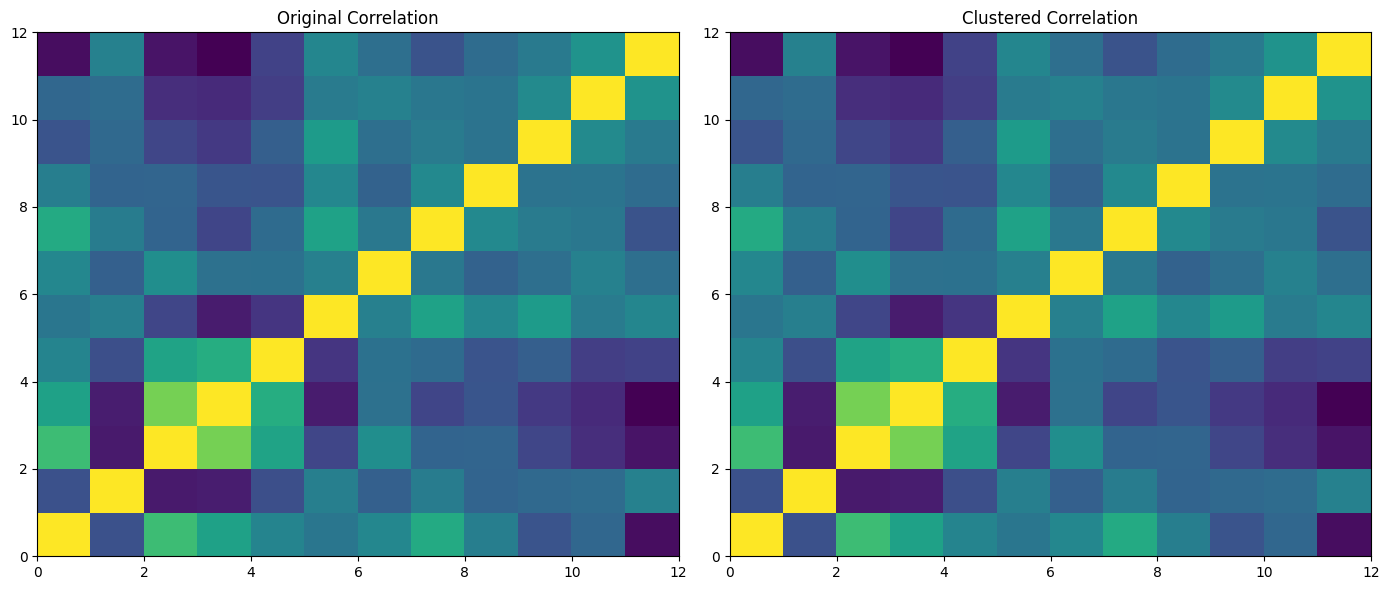

In [18]:
# Apply spectral coclustering
model = SpectralCoclustering(n_clusters=6, random_state=0)
model.fit(flavors)

# Assign group to dataframe
whisky['Group'] = model.row_labels_

# Reorder by group
whisky_sorted = whisky.iloc[np.argsort(model.row_labels_)].reset_index(drop=True)

# Correlation: original vs reordered
corr_original = flavors.corr()
corr_grouped = whisky_sorted.iloc[:, 2:14].corr()

# Visual comparison
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolor(corr_original)
plt.title("Original Correlation")
plt.axis("tight")

plt.subplot(1, 2, 2)
plt.pcolor(corr_grouped)
plt.title("Clustered Correlation")
plt.axis("tight")

plt.tight_layout()
plt.show()


In [19]:
# Mean flavor profile per cluster
cluster_summary = whisky.groupby("Group")[flavors.columns].mean()

# Region count per cluster
region_summary = whisky.groupby(["Group", "Region"]).size().unstack(fill_value=0)

# Display
print("=== Average Flavor Profile per Cluster ===")
display(cluster_summary.round(2))

print("\n=== Region Distribution per Cluster ===")
display(region_summary)


=== Average Flavor Profile per Cluster ===


,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral
Group,,,,,,,,,,,,
0,2.30,1.80,2.50,2.00,0.0,1.10,1.70,0.50,1.60,1.60,1.30,0.90
1,1.50,2.44,1.19,0.25,0.0,0.97,1.22,0.31,1.19,1.78,1.91,2.25
3,3.50,1.50,3.75,3.25,1.0,0.00,1.25,0.75,1.25,1.00,1.00,0.25
4,2.41,2.38,1.32,0.06,0.0,1.74,1.41,1.74,1.76,1.91,2.00,1.56
5,1.83,2.33,1.50,0.67,1.0,1.00,1.67,1.17,1.17,2.17,1.50,1.83



=== Region Distribution per Cluster ===


Region,#####Regions#####,Campbelltown,Highlands,Islands,Islay,Lowlands,Speyside
Group,,,,,,,
0,0,0,4,0,1,0,5
1,0,1,8,3,2,0,18
3,0,0,0,0,2,0,2
4,1,1,7,3,2,3,17
5,0,0,5,0,0,0,1
